In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt

Using Theano backend.


In [2]:
# Initialize the MLP
def initialize_nn(neuron_num, frame_size):
    model = Sequential() # The Keras Sequential model is a linear stack of layers.
    model.add(Dense(neuron_num, init='uniform', input_dim=frame_size)) # Dense layer
    model.add(Activation('tanh')) # Activation layer
    model.add(Dropout(0.5)) # Dropout layer
    model.add(Dense(neuron_num, init='uniform')) # Another dense layer
    model.add(Activation('tanh')) # Another activation layer
    model.add(Dropout(0.5)) # Another dropout layer
    model.add(Dense(2, init='uniform')) # Last dense layer
    model.add(Activation('softmax')) # Softmax activation at the end
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) # Using Nesterov momentum
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) # Using logloss
    return model


def test_nn(input_dim, neuron_num=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neuron_num, input_dim=input_dim, init='uniform', activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron_num, init='uniform', activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, init='uniform', activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def simple_nn(input_dim, neuron_num=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(neuron_num, input_dim=input_dim, init='uniform', activation='tanh'))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(neuron_num, init='uniform', activation='tanh'))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(2, init='uniform', activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
%matplotlib inline  
import pandas as pd
import numpy as np
import os, sys, time
from os.path import join
import yaml

sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils
from utils.bosch_functions import load_processed_bosch_data
from utils.models import CombinedModel, ExtraTreeModel
from utils.validation_tools import score_MCC, create_validation_index, cross_validate_model

In [6]:
'''
## load training data
project_path = '/mnt/home/ymm/kaggle/compete/current'
data_path = '/mnt/home/ymm/kaggle/bosch_data/bosch_complete_processed_data'
data_yaml_file = 'bosch_processed_data_dict.yml'
train = load_processed_bosch_data(data_path, project_path, data_yaml_file, data_index=data_index)
'''

dep_var_name = 'Response'
data_index= '0'

start_time = time.time()
data_path = '/home/ymm/kaggle/bosch_data/bosch_regular_data_features_xgb_feature_10_thres'
train_file_name = 'bosch_processed_regular_filled_thres_10_train_data.csv'
test_file_name = 'bosch_processed_regular_filled_thres_10_test_data.csv'
train = pd.read_csv(join(data_path, train_file_name), index_col='Id')

train_index, valid_index = create_validation_index(train, 0.3, dep_var_name, True)  
valid_data = train.ix[valid_index]
tmp_train  = train.ix[train_index]
print 'finish loading data using {} seconds'.format(round(time.time() - start_time, 1))

finish loading data using 62.6 seconds


In [7]:
tmp_valid_data = valid_data.copy()
valid_data_label = tmp_valid_data[dep_var_name]
valid_data_X = tmp_valid_data.drop(dep_var_name, axis=1).values

In [109]:
nn_train = tmp_train.copy()

In [110]:
nn_train_y = nn_train[dep_var_name]
nn_train_X = nn_train.drop(dep_var_name, axis=1).values
encoded_train_y = np_utils.to_categorical(nn_train_y.values, 2)

In [128]:
init_weight = np.copy(nn_train_y.values)
#pos_weight = int(len(init_weight) / sum(init_weight))
neg_weight =  1. * sum(init_weight) / len(init_weight)

In [118]:
neg_weight

0.0053542119899920165

In [131]:
init_weight = init_weight.astype(float)

In [132]:
#np.place(init_weight, init_weight==1, pos_weight)
#np.place(init_weight, init_weight==0, 1)
np.place(init_weight, init_weight==0., neg_weight)
init_weight = init_weight.astype(float)

In [88]:
#init_weight = init_weight * 1000

In [172]:
#init_weight[:500]

In [27]:
print init_weight.shape, nn_train_X.shape

(336931,) (336931, 436)


In [28]:
input_dim = nn_train_X.shape[1]

In [59]:
#model = simple_nn(input_dim)
#model = initialize_nn(200, input_dim)
model = test_nn(input_dim, 50, 0.01) ## works much better

In [134]:
#weights_list = init_weight.tolist()

In [139]:
from sklearn import preprocessing
scaled_nn_train_X = preprocessing.scale(nn_train_X, with_std=False)

In [ ]:
model.fit(nn_train_X, encoded_train_y,
          batch_size=32, nb_epoch=100,
          verbose=2, callbacks=[],
          validation_split=0.2,
          validation_data=None,
          shuffle=True,
          class_weight=None,
#          sample_weight=None)
          sample_weight=init_weight)
time.sleep(2)


Train on 269544 samples, validate on 67387 samples
Epoch 1/100
35s - loss: 0.0074 - acc: 0.5753 - val_loss: 0.0073 - val_acc: 0.8768
Epoch 2/100
34s - loss: 0.0073 - acc: 0.5872 - val_loss: 0.0073 - val_acc: 0.4956
Epoch 3/100
34s - loss: 0.0073 - acc: 0.5747 - val_loss: 0.0074 - val_acc: 0.8461
Epoch 4/100


In [165]:
y_score = model.predict(valid_data_X)

In [166]:
res_df = pd.DataFrame(y_score)
res_df.columns = ['0', '1']
pred_res = res_df['1']

In [167]:
res_df.head()

,0,1
0,0.620037,0.379963
1,0.620037,0.379963
2,0.620037,0.379963
3,0.620037,0.379963
4,0.441827,0.558173


In [168]:
len(pred_res.unique())

27001

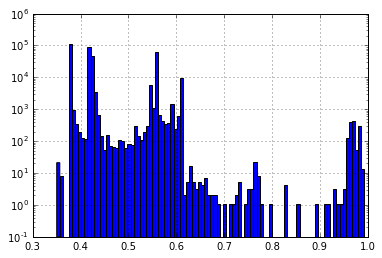

In [169]:
fig, ax = plt.subplots()
res_df['1'].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [170]:
sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
from utils.models import CombinedModel

In [171]:
print 'result from using constant fraction:', score_MCC(valid_data_label, pred_res)
print '\n \n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_data_label, pred_res)

result from using constant fraction: mean of groud truth: 0.00535422788116
threshold for preds: 0.608497500739
0.118896562094

 

result from using flexsible threshold: (0.1384397404096904, 0.9590152502059937)
